# Getting Started

This notebook outlines the best operating practices for mapping a given quantum circuit to real IBM backends. The tools used within build on Qiskit yet not all are contained within this repository. This repository also contains custom transpiler passes that users may construct their own `PassManager`s from. 

In [1]:
from qiskit import IBMQ, transpile
from qiskit.circuit import Parameter, QuantumCircuit
from qiskit.opflow import I, X, Z, PauliTrotterEvolution, Suzuki
from qiskit.providers.fake_provider import FakeMumbai

import numpy as np
import matplotlib.pyplot as plt

plt.style.use("default")

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q-internal", group="deployed", project="default")

## Problem: Quantum Simulation

As an example, we'll use the problem statement from [this manuscript](https://arxiv.org/abs/2108.09197), the quantum simulation of an Ising model Hamiltonian:
$$
H = -J \sum_{\langle i,j \rangle} Z_i Z_j + h \sum_i X_i
$$
where $J$ is the exchange coupling between adjacent spins and $h$ is the transverse magnetic field. Here $X_i$ and $Z_j$ are the Pauli matrices acting on qubits $i$ and $j$, respectively. This model describes an interacting system of spins in a magnetic field, which is normally a nearest-neighbor interaction, in order to highlight the mapping of this problem to quantum hardware, we make it an all-to-all interaction. <br> <br>

We will use tools from `qiskit.opflow` to generate the circuits needed for the simulation. The Hamiltonian $H$ is formed by instantiating `Parameter`s and building the interactions from the Pauli matrices `I`, `X`, and `Z` by concatenating them in tensor products ($\otimes$) represented in `opflow` by the caret symbol `^`. The formal solution to Schrödinger's equation is
$$
U = e^{-iHt},
$$
the *time-evolution unitary* corresponding to Hamiltonian evolution under $H$, and is found formally using the `.exp_i()` on an operator expression.

In [3]:
num_spins = 3

JJ = Parameter("J")
hh = Parameter("h")
tt = Parameter("t")

ham = -JJ * sum(
    [
        sum(
            [
                (I ^ idx) ^ Z ^ (I ^ jdx) ^ Z ^ (I ^ (num_spins - idx - jdx - 2))
                for jdx in range(num_spins - idx - 1)
            ]
        )
        for idx in range(num_spins - 1)
    ]
) + hh * sum([(I ^ idx) ^ X ^ (I ^ (num_spins - idx - 1)) for idx in range(num_spins)])
U_ham = (ham * tt).exp_i()
print(U_ham)

e^(-i*1.0*t * SummedOp([
  -1.0*J * (
    1.0 * ZZI
    + 1.0 * ZIZ
    + 1.0 * IZZ
  ),
  1.0*h * (
    1.0 * XII
    + 1.0 * IXI
    + 1.0 * IIX
  )
]))


## Converting Operators to Circuits

The `qiskit.opflow` module contains methods to convert the time-evolved operators (`EvolvedOp`s) to circuits. One common method is the Suzuki-Trotter decomposition, in which the total evolution time $t$ is broken into `num_steps` $N$. By choosing the second-order of the `PauliTrotterEvolution`, we create a circuit that acts like our unitary to second order $\mathcal{O}((t/N)^2)$. 

Practically, since many of the following transpilation steps are computationally intensive, it may make sense to break up your circuit into smaller subcircuits, and then combine them together to get the final circuit. This is naturally acheived for Trotterized algorithms, since `reps` here just repeats the same circuit `num_steps` times, hence we just set `num_steps=1` and the resulting circuits can be combined into as many steps as desired later.

Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.


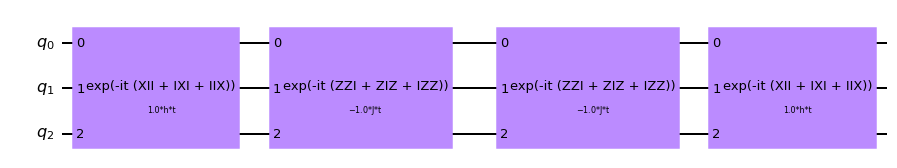

In [4]:
num_steps = 1
trot_circ = (
    PauliTrotterEvolution(trotter_mode=Suzuki(order=2, reps=num_steps))
    .convert(U_ham)
    .to_circuit()
)
trot_circ.draw("mpl")

## Transpile for Good SWAP Mapping

In general problems must respect the layout of the actual quantum hardware. Due to limited connectivity, this often entails doing SWAP operations to move quantum information around. SWAPs are costly in the sense they consist of three `CX`s. The Qiskit transpiler with `optimization_level=3` uses the [SABRE SWAP method](https://arxiv.org/abs/1809.02573), which is efficient, however stochastic, since the SWAP-mapping problem is NP-hard. Here we do it several time and take the solution with the lowest CNOT count. This operation serves only to minimize the number of SWAPs in the transpiled circuits, and is not aware of noise on the underlying qubits. That is considered in a following step.

In [5]:
# TODO - check issue with floats not being rounded off

num_tries = 10

# backend = FakeMumbai()
# backend = provider.get_backend('ibmq_mumbai')
backend = provider.get_backend("ibm_lagos")
trot_circ_ts = transpile(
    [trot_circ] * num_tries, backend, optimization_level=3, seed_transpiler=12345
)
cx_counts = [trot_circ_ts[idx].count_ops()["cx"] for idx in range(num_tries)]
print(cx_counts)

[26, 26, 26, 26, 26, 26, 26, 26, 26, 26]


In [6]:
best_idx = np.argmin(cx_counts)
trot_circ_t = trot_circ_ts[best_idx]

## Noise-aware Layout

Now that we have a SWAP-mapped optimal circuit, we consider the layouts on the actual quantum backend. These layouts are found by the VF2 subgraph isomorphism algorithm, which is very fast. Since the transpiler mapped the circuit to physical qubits, we must first "deflate" the circuits with `deflate_circuit` (which removes idle qubits), finds the layouts with `matching_layouts`, then scores those layouts due to error rates, which are calculated by a cost function that may be specified by the user, see [`mapomatic`](https://github.com/Qiskit-Partners/mapomatic) documentation for how. The default cost function includes errors determined for each qubit gates and measurements, although not decoherence/relaxation caused by idle time, producing an *infidelity score* where the lowest number is the preferred layout.

In [7]:
from mapomatic import deflate_circuit, evaluate_layouts, matching_layouts

trot_circ_def = deflate_circuit(trot_circ_t)
layouts = matching_layouts(trot_circ_def, backend)
scored_layouts = evaluate_layouts(
    trot_circ_def, layouts, backend
)  # cost_function = cost_func
print(scored_layouts)

[([4, 5, 6], 0.12719251234702322), ([6, 5, 4], 0.1300224714618584), ([3, 5, 6], 0.19264176299560232), ([3, 1, 0], 0.20309221741061256), ([0, 1, 3], 0.20333737334577995), ([6, 5, 3], 0.20524973331633678), ([3, 5, 4], 0.21298874623783082), ([4, 5, 3], 0.22275887317516874), ([2, 1, 0], 0.24245668326093384), ([5, 3, 1], 0.24281242029570504), ([2, 1, 3], 0.24785335795590058), ([0, 1, 2], 0.2480742310482451), ([1, 3, 5], 0.24886169314179551), ([3, 1, 2], 0.2532011460819723)]


## Pulse Scaling

For certain problems, in particular Trotterized quantum simulation problems, or other algorithms that require small angles of rotation in the two-qubit Hilbert space, it is more efficient to implement operations in terms of pulses extracted from the CNOT gate. Basically, a CNOT gate is *locally-equivalent* to an $R_{ZX}(\pi/2)$ rotation, meaning it is built from that and single-qubit rotations, as can be seen from the following code:

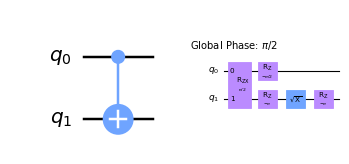

In [8]:
# TODO: check out Weyl decomp stuff

qc = QuantumCircuit(2)
qc.cx(0, 1)
qc_rzx = transpile(qc, basis_gates=["sx", "rz", "rzx"])

fig, (ax1, ax2) = plt.subplots(1, 2)
qc.draw("mpl", ax=ax1)
qc_rzx.draw("mpl", ax=ax2)

The `RZXGate` is very similar to the native two-qubit interation called [echoed cross resonance](https://arxiv.org/abs/1603.04821) which is used to create entanglement on IBM backends. In particular, many two-qubit interactions for quantum simulation, such as the $ZZ$-interaction of our Ising Hamiltonian, can be more efficiently represented (in terms of error) by $R_{ZX}(\theta)$ rotations, which are automatically broken into scaled echoed cross resonance `secr` gates unless `unroll_rzx_to_ecr` is set to `False`.

In [9]:
from qiskit_research.utils.convenience import scale_cr_pulses

theta = Parameter("$\\theta$")

qc = QuantumCircuit(2)
qc.rzz(theta, 0, 1)
qc_cx = transpile(qc, basis_gates=["rz", "sx", "cx"])
qc_rzx = scale_cr_pulses(qc_cx, backend)  # unroll_rzx_to_ecr = True, param_bind = {}

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))
qc.draw("mpl", ax=ax1)
qc_cx.draw("mpl", ax=ax2)
qc_rzx.draw("mpl", ax=ax3)
ax2.set_title("These are all equivalent circuits")

ModuleNotFoundError: No module named 'qiskit.transpiler.passes.calibration.base_builder'

When we are implementing two-qubit rotation angles $\theta$ less than $\pi/2$, we can more efficiently express these interaction in terms of $R_{ZX}(\theta)$ rotations and directly build them from scaled echoed cross resonance (`secr`($\theta$)) pulses obtained from the backend, as detailed in [this manuscript](http://arxiv.org/abs/2012.11660). This method first uses a greedy algorithm called [template opimization](http://arxiv.org/abs/1909.05270) to identify parts of the circuit that can be substituted by $R_{ZX}$ rotations. If parameters are passed to the method via `param_bind`, it will bind them to the circuit and attach the necessary pulse gates for implementing the $R_{ZX}$ rotations (otherwise they can be bound and scaled later with `attach_cr_pulses`). Below we will do them separately, because we will attach a series of `Parameter`s as a function of time, and it is more efficient to do the template optimization step once since it is greedy and attaching the pulse schedules in quick.

In [ ]:
my_layout = scored_layouts[0][0]  # the layout with the lowest score (i.e., error)
trot_circ_sca = scale_cr_pulses(
    transpile(trot_circ_def, initial_layout=my_layout), backend
)
trot_circ_sca.draw("mpl", idle_wires=False)

In [ ]:
from qiskit_research.utils.convenience import attach_cr_pulses

num_time_steps = 51
t_range = np.linspace(0, 10, num_time_steps)  # values from manuscript
param_bind = {JJ: 0.5236, hh: 1}  # values from manuscript

circs = []
for t_set in t_range:
    param_bind[tt] = t_set
    circs.append(attach_cr_pulses(trot_circ_sca, backend, param_bind))

## Pauli Twirling

Pauli twirling is a form of randomized compiling that inserts pairs of Pauli gates (`I`, `X`, `Y`, `Z`) before and after entangling gates such that the overall unitary is the same, but the way it is implemented is different. This has the effect of turning coherent errors into stochastic errors, which can then be elimated by sufficient averaging. This is done a number of times (`num_twirled_circuits`) for the benefit of averaging. **Note:** we are probably using an insufficient basis set to currently cancel all errors.

In [ ]:
from qiskit_research.utils.convenience import add_pauli_twirls

num_twirls = 5
# this returns a circuit with shape len(circs) x num_twirled_circuits
twirled_circs = add_pauli_twirls(
    circs, num_twirled_circuits=num_twirls, seed=12345
)  # transpile_added_paulis = False

In [ ]:
twirled_circs[-1][-1].draw("mpl", idle_wires=False)

Look good! Now before proceeding to dynamical decoupling, we must convert to the native basis gates of the backend so that we can retrieve gate timing information, which is necessary to add dynamical decoupling passes. (Unless you set the keyword argument `transpile_added_paulis=True` in the above). You will also need to run this before running on a backend.

In [ ]:
from qiskit_research.utils.convenience import transpile_paulis

twirled_circs_t = transpile_paulis(twirled_circs)

## Dynamical Decoupling

Dynamical decoupling (DD) is a way of modifying the noise power spectrum $S(\omega)$ observed by qubits (see [this recent review](https://arxiv.org/abs/2207.03670)), and is typically implemented by a sequence of gates scheduled during a given qubit idle time that compose to the identity with specific delay times to fill the idle time in a calculated manner. Considerations for which sequences to use may involve decoherent error due to idle time versus single-qubit gate errors and/or crosstalk during two-qubit gates. Because the addition of gates is not always in the set of `basis_gates` defined by the backend, `add_pulse_cals=True` uses [Pulse Gates](https://qiskit.org/documentation/tutorials/circuits_advanced/05_pulse_gates.html) to add the correct implementation to the circuit with added DD.

In [ ]:
from qiskit_research.utils.convenience import add_dynamical_decoupling

twirled_circs_with_dd = add_dynamical_decoupling(
    twirled_circs_t, backend, "XY8", add_pulse_cals=True
)

In [ ]:
from qiskit.visualization import timeline_drawer

# this just displays a small range
timeline_drawer(twirled_circs_with_dd[-1][-1], time_range=[1, 12000], show_idle=False)

## Circuit Execution

This runs the given circuits on the backend. This will be expanded to include different methods of running, i.e. Qiskit Runtime. 

In [ ]:
# the backend only accepts a QuantumCircuit or List[QuantumCircuit]
flattened_circs = [
    circ for circs in twirled_circs_with_dd for circ in circs
]  # first 5 circs are same Pauli twirled circuit at same time
counts = backend.run(flattened_circs).result().get_counts()

## Measurement Error Mitigation

This uses `mthree` (matrix-free measurement mitigation) to do $LU$-decomposition on a readout calibration routine to efficently correct for readout errors. Note that `cals_from_system` runs an experiment on your chosen `backend` and then applies it to your results to calculate quasi-probabilities, with the default `num_shots=8192`.

In [ ]:
from mthree import M3Mitigation

mit = M3Mitigation(backend)
mit.cals_from_system(my_layout)

In [ ]:
# apply the correction
quasi_probs = mit.apply_correction(counts, my_layout)

In [ ]:
# collect quasi-probabilities from different Pauli twirls
quasi_probs_twirled = []
for time_idx in range(num_time_steps):
    quasi_prob_twirled = {}
    for twidx in range(num_twirls):
        for key in quasi_probs[time_idx * num_twirls + twidx].keys():
            try:
                quasi_prob_twirled[key] += (
                    quasi_probs[time_idx * num_twirls + twidx][key] / num_twirls
                )
            except:
                quasi_prob_twirled[key] = (
                    quasi_probs[time_idx * num_twirls + twidx][key] / num_twirls
                )

    quasi_probs_twirled.append(quasi_prob_twirled)

In [ ]:
# separate list of dicts into dict of lists
quasi_probs_dict = {}
for time_step in quasi_probs_twirled:
    for key in time_step.keys():
        try:
            quasi_probs_dict[key].append(time_step[key])
        except:
            quasi_probs_dict[key] = [time_step[key]]

In [ ]:
# plot results
fig, ax = plt.subplots(figsize=(12, 4))
for key in quasi_probs_dict.keys():
    ax.plot(t_range, quasi_probs_dict[key], lw=2, label=key)
ax.set_xlabel("time step (arb)")
ax.set_ylabel("quasi-probability")
ax.legend(loc=4)
plt.show()